In [0]:
# This code is used for JHU CS 482/682: Deep Learning 2019 Spring Project
# Copyright: Zhaoshuo Li, Ding Hao, Mingyi Zheng
!pip install tensorboardX visdom image_slicer
import os

import torch
import torchvision
from torch import nn
from torch.autograd import Variable
import torch.nn.functional as functional
from torch.utils.data import DataLoader, Dataset
#from torchvision import transforms
import torchvision.transforms.functional as TF
from albumentations import *
import copy
import numpy as np
import random
from tensorboardX import SummaryWriter

#import transforms
from dataset import *
from visualization import *
from label_conversion import *
from dice_loss import *
from model_trainning import *
from model_from_ternaus import *
from deeplabv3p_resnet_super_label import SuperLabelDeepLabv3_plus
from unet import *

from google.colab import drive
drive.mount('/mydrive')

Drive already mounted at /mydrive; to attempt to forcibly remount, call drive.mount("/mydrive", force_remount=True).


In [0]:
# os.environ["CUDA_VISIBLE_DEVICES"]="2"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:
print(device)

cuda


# Seed pytorch and numpy and random

In [0]:
# IMPORTANT!
# must seed the same value each time when training a new network
seed = 256
random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)
pretrain_seed = 128

## Hyperparameters

In [0]:
train_batch_size = 10
validation_batch_size=10
learning_rate = 0.001
num_epochs = 50
num_class = 12
num_superclasses = 2
super2sub = [[0,4,5,6,10],[1,2,3,7,8,9,11]]
num_filters = 64

In [0]:
#dice_loss = BatchWeightDICELoss()
weights = torch.ones((num_class,1)).to(device = device)
dice_loss = SuperLabelDICELoss(weights,_lambda=0.5) 
# dice_loss = DICELoss(weights)

## Visualization

In [0]:
# Initialize the visualization environment
writer = SummaryWriter()

## Unet

In [0]:
#initialize model
model = SuperLabelDeepLabv3_plus(nInputChannels=3, n_super_classes = num_superclasses, n_classes=num_class, os=16, pretrained=True, _print=True,  super2sub = super2sub)
#model_dict = model.state_dict()
# pretrained_dict = torch.load("/mydrive/My Drive/Colab Notebooks/trained_albunet.pt")
# pretrained_dict = {k: v for k, v in pretrained_dict.items() if (k in model_dict and "final" not in k)}
# 2. overwrite entries in the existing state dict
# model_dict.update(pretrained_dict) 
# 3. load the new state dict
# model.load_state_dict(model_dict)
# freeze the pretrained feature.
# for param in model.parameters():
#     param.requires_grad = False
# for param in model.super_class_classifier.parameters():
#     param.requires_grad = True
# for param in model.final_classifier.parameters():
#     param.requires_grad = True
# model = AlbuNet(num_classes = num_class,num_filters = num_filters, pretrained = True, is_deconv = True)
model.to(device)

Constructing DeepLabv3+ model...
Number of classes: 12
Output stride: 16
Number of Input Channels: 3


SuperLabelDeepLabv3_plus(
  (resnet_features): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (downsample): Sequent

## Optimizer and Scheduler and loss

In [0]:
# intialize optimizer and lr decay
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.95)

## Baseline Unet16 (unet with vgg16 backbone not pretrained), without augmentation.

In [0]:
# IMPORTANT!
# must seed the same value each time when training a new network
seed = 256
random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)

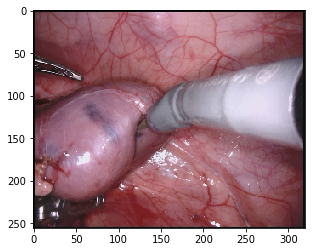

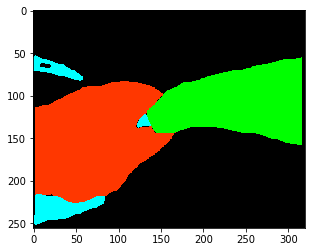

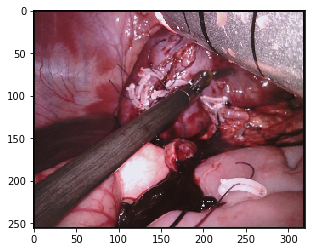

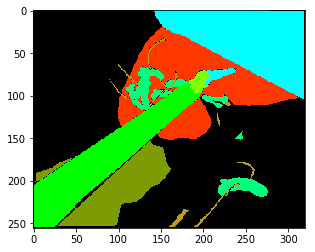

In [0]:
# define transform
image_aug = Compose([
    Normalize(mean=(0.5,0.5,0.5),std=(0.5,0.5,0.5),p=1),
])
train_dataset = MICCAIDataset(data_path = "/mydrive/My Drive/Colab Notebooks/data/",data_type = "train", transform_image=image_aug)
validation_dataset = MICCAIDataset(data_path = "/mydrive/My Drive/Colab Notebooks/data/",data_type = "validation", transform_image=image_aug)
label_converter = LabelConverter(data_path = "/mydrive/My Drive/Colab Notebooks/data/")

# # show one example
img,label = (train_dataset[0]['img'],train_dataset[0]['label'])
imshow(img.permute(1,2,0),denormalize=True)
colorlabel = train_dataset.label_converter.label2color(label.permute(1,2,0))
imshow(colorlabel)

# show one example
img,label = (validation_dataset[0]['img'],validation_dataset[0]['label'])
imshow(img.permute(1,2,0),denormalize=True)
colorlabel = train_dataset.label_converter.label2color(label.permute(1,2,0))
imshow(colorlabel)

In [0]:
# intialize the dataloader
train_generator = DataLoader(train_dataset,shuffle=True,batch_size=train_batch_size,num_workers=8)
validation_generator = DataLoader(validation_dataset,shuffle=True,batch_size=validation_batch_size,num_workers=8)

## Start training

In [0]:
best_model_wts, best_acc = run_training(model,device,num_class,scheduler,optimizer,dice_loss,num_epochs,train_generator,train_dataset,validation_generator,validation_dataset,writer)

Training Started!

EPOCH 1 of 50

Training Loss: 0.7163
0 Class, True Pos 35373560.0, False Pos 11132697.0, False Neg 17780884.0, Num Pixel 53154444.0, Dice score 0.71
1 Class, True Pos 9109253.0, False Pos 3571734.0, False Neg 1822731.0, Num Pixel 10931984.0, Dice score 0.77
2 Class, True Pos 3446835.0, False Pos 3619022.0, False Neg 1911079.0, Num Pixel 5357914.0, Dice score 0.55
3 Class, True Pos 1120186.0, False Pos 1375208.0, False Neg 1359259.0, Num Pixel 2479445.0, Dice score 0.45
4 Class, True Pos 12746391.0, False Pos 8873222.0, False Neg 7355766.0, Num Pixel 20102156.0, Dice score 0.61
5 Class, True Pos 8716965.0, False Pos 5907597.0, False Neg 4986320.0, Num Pixel 13703285.0, Dice score 0.62
6 Class, True Pos 5239.0, False Pos 54177.0, False Neg 413889.0, Num Pixel 419128.0, Dice score 0.02
7 Class, True Pos 121280.0, False Pos 286557.0, False Neg 492022.0, Num Pixel 613302.0, Dice score 0.24
8 Class, True Pos 0.0, False Pos 107057.0, False Neg 4192.0, Num Pixel 4192.0, Dice

In [0]:
## load best model weights
model.load_state_dict(best_model_wts)
## save model
torch.save(model.state_dict(), '/mydrive/My Drive/Colab Notebooks/super_label_albunet.pt')

## Test

In [0]:
# load test dataset
test_dataset=MICCAIDataset(data_path = "/mydrive/My Drive/Colab Notebooks/data/",data_type = "test", transform_image=image_aug)
test_generator=DataLoader(test_dataset,shuffle=False,batch_size=4,num_workers=8)

In [0]:
# load model
model.load_state_dict(torch.load('/mydrive/My Drive/Colab Notebooks/super_label_albunet.pt'))
model.to(device)
print("Model loaded")

Model loaded


In [0]:
  final_dice = test(model,device,dice_loss,num_class,test_generator,test_dataset,writer)

Dice Score: 0.8630
0 Class, True Pos 16120857.0, False Pos 596842.0, Flase Neg 599612.0
1 Class, True Pos 3029695.0, False Pos 146409.0, Flase Neg 126734.0
2 Class, True Pos 1596763.0, False Pos 172473.0, Flase Neg 243393.0
3 Class, True Pos 765283.0, False Pos 113824.0, Flase Neg 102979.0
4 Class, True Pos 6275180.0, False Pos 295335.0, Flase Neg 237623.0
5 Class, True Pos 4038948.0, False Pos 174584.0, Flase Neg 171560.0
6 Class, True Pos 87064.0, False Pos 27229.0, Flase Neg 44666.0
7 Class, True Pos 139193.0, False Pos 14640.0, Flase Neg 23598.0
8 Class, True Pos 117.0, False Pos 147.0, Flase Neg 221.0
9 Class, True Pos 134704.0, False Pos 11546.0, Flase Neg 17270.0
10 Class, True Pos 2563332.0, False Pos 97373.0, Flase Neg 82156.0
11 Class, True Pos 197655.0, False Pos 19047.0, Flase Neg 19637.0
----------


# Data Augmentation

In [0]:
# IMPORTANT!
# must seed the same value each time when training a new network
seed = 256
random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)

In [0]:
#initialize model
model = SuperLabelDeepLabv3_plus(nInputChannels=3, n_super_classes = num_superclasses, n_classes=num_class, os=16, pretrained=True, _print=True,  super2sub = super2sub)
#model_dict = model.state_dict()
# pretrained_dict = torch.load("/mydrive/My Drive/Colab Notebooks/trained_albunet.pt")
# pretrained_dict = {k: v for k, v in pretrained_dict.items() if (k in model_dict and "final" not in k)}
# 2. overwrite entries in the existing state dict
# model_dict.update(pretrained_dict) 
# 3. load the new state dict
# model.load_state_dict(model_dict)
# freeze the pretrained feature.
# for param in model.parameters():
#     param.requires_grad = False
# for param in model.super_class_classifier.parameters():
#     param.requires_grad = True
# for param in model.final_classifier.parameters():
#     param.requires_grad = True
# model = AlbuNet(num_classes = num_class,num_filters = num_filters, pretrained = True, is_deconv = True)
model.to(device)

Constructing DeepLabv3+ model...
Number of classes: 12
Output stride: 16
Number of Input Channels: 3


SuperLabelDeepLabv3_plus(
  (resnet_features): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (downsample): Sequent

In [0]:
# intialize optimizer and lr decay
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.95)

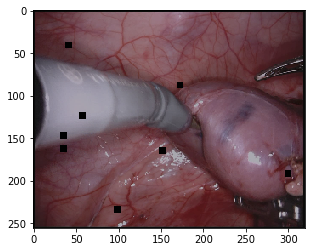

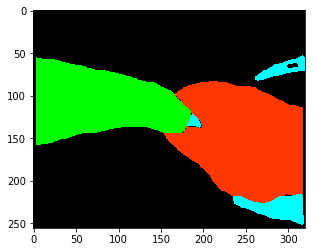

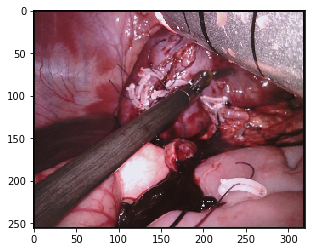

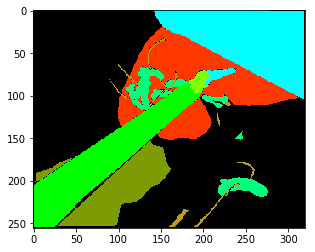

In [0]:
# define transform
train_both_aug = Compose([
    Cutout(num_holes=8,p=0.5),
    OneOf([
        ShiftScaleRotate(p=0.5),
        HorizontalFlip(p=0.8),
    ])
])
train_image_aug = Compose([
    OneOf([
        RandomBrightnessContrast(brightness_limit=(-0.2,0.2), contrast_limit=(-0.5,0.5),p=0.9),
        RandomGamma(gamma_limit=(50,200),p=0.8),
        MotionBlur(blur_limit=10,p=0.7),
        HueSaturationValue(hue_shift_limit=0,p=0.8)            
    ]),
    Normalize(mean=(0.5,0.5,0.5),std=(0.5,0.5,0.5),p=1),
])

val_image_aug = Compose([
    Normalize(mean=(0.5,0.5,0.5),std=(0.5,0.5,0.5),p=1),
])
train_dataset = MICCAIDataset(data_path = "/mydrive/My Drive/Colab Notebooks/data/",data_type = "train", transform_both=train_both_aug, transform_image=train_image_aug)
validation_dataset = MICCAIDataset(data_path = "/mydrive/My Drive/Colab Notebooks/data/",data_type = "validation", transform_image=val_image_aug)
label_converter = LabelConverter(data_path = "/mydrive/My Drive/Colab Notebooks/data/")

# # show one example
img,label = (train_dataset[0]['img'],train_dataset[0]['label'])
imshow(img.permute(1,2,0),denormalize=True)
colorlabel = train_dataset.label_converter.label2color(label.permute(1,2,0))
imshow(colorlabel)

# show one example
img,label = (validation_dataset[0]['img'],validation_dataset[0]['label'])
imshow(img.permute(1,2,0),denormalize=True)
colorlabel = train_dataset.label_converter.label2color(label.permute(1,2,0))
imshow(colorlabel)

In [21]:
best_model_wts, best_acc = run_training(model,device,num_class,scheduler,optimizer,dice_loss,num_epochs,train_generator,train_dataset,validation_generator,validation_dataset,writer)

Training Started!

EPOCH 1 of 50

Training Loss: 0.6964
0 Class, True Pos 36026696.0, False Pos 10193129.0, False Neg 17127756.0, Num Pixel 53154452.0, Dice score 0.73
1 Class, True Pos 8836753.0, False Pos 3171286.0, False Neg 2095231.0, Num Pixel 10931984.0, Dice score 0.77
2 Class, True Pos 3338996.0, False Pos 3228177.0, False Neg 2018918.0, Num Pixel 5357914.0, Dice score 0.56
3 Class, True Pos 1427878.0, False Pos 1861394.0, False Neg 1051567.0, Num Pixel 2479445.0, Dice score 0.50
4 Class, True Pos 12898886.0, False Pos 8407804.0, False Neg 7203271.0, Num Pixel 20102156.0, Dice score 0.62
5 Class, True Pos 9282422.0, False Pos 6414061.0, False Neg 4420863.0, Num Pixel 13703285.0, Dice score 0.63
6 Class, True Pos 31632.0, False Pos 149018.0, False Neg 387496.0, Num Pixel 419128.0, Dice score 0.11
7 Class, True Pos 164467.0, False Pos 283916.0, False Neg 448835.0, Num Pixel 613302.0, Dice score 0.31
8 Class, True Pos 0.0, False Pos 146776.0, False Neg 4192.0, Num Pixel 4192.0, Di

# Pretraining